# Построение линейных регрессионных моделей в теории и методике спорта

# Введение

https://habr.com/ru/post/514818/

Есть три сходных между собой понятия: интерполяция, аппроксимация и регрессия.
У них общая цель: из семейства функций выбрать ту, которая обладает определенным свойством.


**Интерполяция** — способ выбрать из семейства функций ту, которая проходит через заданные точки. Часто функцию затем используют для вычисления в промежуточных точках. Например, мы вручную задаем цвет нескольким точкам и хотим чтобы цвета остальных точек образовали плавные переходы между заданными. Или задаем ключевые кадры анимации и хотим плавные переходы между ними. Классические примеры: интерполяция полиномами Лагранжа, сплайн-интерполяция, многомерная интерполяция (билинейная, трилинейная, методом ближайшего соседа и т.д). Есть также родственное понятие экстраполяции — предсказание поведения функции вне интервала. Например, предсказание курса доллара на основании предыдущих колебаний — экстраполяция.

**Аппроксимация** — способ выбрать из семейства «простых» функций приближение для «сложной» функции на отрезке, при этом ошибка не должна превышать определенного предела. Аппроксимацию используют, когда нужно получить функцию, похожую на данную, но более удобную для вычислений и манипуляций (дифференцирования, интегрирования и т.п). При оптимизации критических участков кода часто используют аппроксимацию: если значение функции вычисляется много раз в секунду и не нужна абсолютная точность, то можно обойтись более простым аппроксимантом с меньшей «ценой» вычисления. Классические примеры включают ряд Тейлора на отрезке, аппроксимацию ортогональными многочленами, аппроксимацию Паде, аппроксимацию синуса Бхаскара и т.п.

**Регрессия** — способ выбрать из семейства функций ту, которая минимизирует функцию потерь. Последняя характеризует насколько сильно пробная функция отклоняется от значений в заданных точках. Если точки получены в эксперименте, они неизбежно содержат ошибку измерений, шум, поэтому разумнее требовать, чтобы функция передавала общую тенденцию, а не точно проходила через все точки. В каком-то смысле регрессия — это «интерполирующая аппроксимация»: мы хотим провести кривую как можно ближе к точкам и при этом сохранить ее максимально простой чтобы уловить общую тенденцию. За баланс между этими противоречивыми желаниями как-раз отвечает функция потерь (в английской литературе «loss function» или «cost function»)

Цель регрессии — найти коэффициенты этой линейной комбинации, и тем самым определить регрессионную функцию $f$ (которую также называют моделью). Отмечу, что линейную регрессию называют линейной именно из-за линейной комбинации базисных функций — это не связано с самыми базисными функциями (они могут быть линейными или нет).

Впервые метод опубликовал Лежандр в 1805 году, хотя Гаусс пришел к нему раньше и успешно использовал для предсказания орбиты «кометы» (на самом деле карликовой планеты) Цереры. Существует множество вариантов и обобщений линейной регрессии: LAD, метод наименьших квадратов, Ridge регрессия, Lasso регрессия, ElasticNet и многие другие. https://scikit-learn.ru/1-1-linear-models/

В простом случае мы имеем известное вам со школы линейное уранвение, где зависимая пременная $y$ определяется независимой переменной $x$:

$$
y=a+bx+c
$$



In [ ]:
#@title #Имитация линейной регрессии. Перемещайтекрасные квадраты для изменения области значений данных и добейтесь "хорошей" и "плохой" корреляции. Источник (https://github.com/fbeilstein).

%%html

<html>

<head>
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script> 
  <script src='https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=default'></script>

  <script type="application/javascript">

    function mean(idx) {
      var sum = 0.0;
      var num = 0;
      if (active_pt && active_pt[0] > 0 && active_pt[0] < 600 && active_pt[1] > 0 && active_pt[1] < 600) {
        sum = active_pt[idx];
        num = 1;
      }
      all_pts.forEach(function (item, index) {
          sum += item[idx];
          num += 1;
        });
      return sum / num;
    }

    function coef(m_x, m_y) {
      cov_xy = 0.0;
      s_x2 = 0.0;
      s_y2 = 0.0;
      all_pts.forEach(function (item, index) {
          dx = item[0] - m_x;
          dy = item[1] - m_y;
          cov_xy += dx * dy;
          s_x2 += dx * dx;
          s_y2 += dy * dy;
        });
      cov_xy /= all_pts.length;
      s_x2 /= all_pts.length;
      s_y2 /= all_pts.length;
      return [s_x2, cov_xy];
    }


   function gaussian(x, mu, sigma) {
   	 return Math.exp(-(x - mu)*(x - mu)/sigma/sigma/2)/sigma/Math.sqrt(2 * Math.PI);
   }
   function random_point(mu, sigma) {
   	 var z = Math.sqrt(-2.0 * Math.log(Math.random())) * Math.cos(2.0 * Math.PI * Math.random());
   	 return z * sigma + mu;
   }

    var active_pt = null;
    var all_pts = [];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function regenerate() {
      var elem = document.getElementById("samples_val");
      var samples = parseInt(elem.value);
      var pos = all_pts[0];
      all_pts = [pos];
      var vx = [pos[3] - pos[0], pos[4] - pos[1]];
      var vy = [pos[5] - pos[0], pos[6] - pos[1]];
      var rx = Math.sqrt(vx[0]*vx[0] + vx[1]*vx[1]);
      var ry = Math.sqrt(vy[0]*vy[0] + vy[1]*vy[1]);
      vx = [vx[0]/rx, vx[1]/rx];
      vy = [vy[0]/ry, vy[1]/ry];
      for (var i = 0; i < samples; ++i) {
        var gaus_x = random_point(0, rx/2.0);
        var gaus_y = random_point(0, ry/2.0);
        all_pts.push([vx[0]*gaus_x + vy[0]*gaus_y + pos[0], vx[1]*gaus_x + vy[1]*gaus_y + pos[1], 0]);
      }
    }


    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      if (pos[2] == 0) {
      	  ctx.fillStyle = 'rgba(128, 128, 128, 0.5)';
          ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
          ctx.fill();
      } else {
      	  ctx.fillStyle = 'rgba(0, 89, 208, 0.4)';
          ctx.fillRect(pos[0] - ptR, pos[1] - ptR, 2 * ptR, 2 * ptR);
          ctx.fillStyle = 'rgba(128, 0, 0, 1.0)';
          ctx.fillRect(pos[3] - ptR/2, pos[4] - ptR/2, ptR, ptR);
          ctx.fillRect(pos[5] - ptR/2, pos[6] - ptR/2, ptR, ptR);
          ctx.fillStyle = 'rgba(128, 0, 0, 0.1)';
          var rx = Math.sqrt((pos[4] - pos[1])*(pos[4] - pos[1]) + (pos[3] - pos[0])*(pos[3] - pos[0]));
          var ry = Math.sqrt((pos[6] - pos[1])*(pos[6] - pos[1]) + (pos[5] - pos[0])*(pos[5] - pos[0]));
          ctx.ellipse(pos[0], pos[1], rx, ry, Math.atan2(pos[4] - pos[1], pos[3] - pos[0]), 0, Math.PI * 2.0);
          ctx.fill();
      }
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeStyle = 'black';
        ctx.lineWidth = 2.0;
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, active_pt);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, item);

        });
        circ(ctx, all_pts[0]);

        if (!active_pt) {
          var temp = all_pts.shift();
          var m_x = mean(0);
          var m_y = mean(1);
          var corr = coef(m_x, m_y);
          //ctx.fillStyle = 'black';
          //ctx.fillText('Coef: ' + corr.toFixed(5), 20, 30);
          all_pts.unshift(temp);

          if (corr && corr[0] && corr[1]) {
            //ctx.fillStyle = 'black';
            //ctx.fillText('Coef: ' + corr[0].toFixed(5) + '    ' + corr[1].toFixed(5), 20, 30);
            ctx.strokeStyle = 'blue';
            ctx.beginPath();
            ctx.moveTo(m_x - 100.0 * corr[0], m_y - 100.0 * corr[1]);
            ctx.lineTo(m_x + 100.0 * corr[0], m_y + 100.0 * corr[1]);
            ctx.stroke();          
          }

        }


      }
    }
    
    var timer

    function mdown_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      idx = -1;
      var item = all_pts[0];
      var index = 0;
      //all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        if (item[2] == 1)
          	item[7] = 0;
        }
        if (item[2] == 1 && is_close([x,y], [item[3], item[4]])) {
        	item[7] = 1;
        	idx = index;
        }
        if (item[2] == 1 && is_close([x,y], [item[5], item[6]])) {
        	item[7] = 2;
        	idx = index;
        }
      //});
      if (idx <= -1)
          return;

    active_pt = all_pts[idx];
    all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
      	if (active_pt[2] == 0) {
      		active_pt[0] = x;
        	active_pt[1] = y;
      	}
        if (active_pt[2] == 1) {
        	if (active_pt[7] == 0) {
            	active_pt[3] += x - active_pt[0];
            	active_pt[4] += y - active_pt[1];
            	active_pt[5] += x - active_pt[0];
            	active_pt[6] += y - active_pt[1];
            	active_pt[0] = x;
        		active_pt[1] = y;
            }
            if (active_pt[7] == 1) {
            	active_pt[3] = x;
            	active_pt[4] = y;
            	var v_x = active_pt[3] - active_pt[0];
            	var v_y = active_pt[4] - active_pt[1];
            	var r = Math.sqrt(v_x*v_x + v_y*v_y);
            	var u_x = active_pt[5] - active_pt[0];
            	var u_y = active_pt[6] - active_pt[1];
            	var R = Math.sqrt(u_x*u_x + u_y*u_y);
            	active_pt[5] = active_pt[0] - v_y / r * R;
            	active_pt[6] = active_pt[1] + v_x / r * R;
            }
            if (active_pt[7] == 2) {
            	active_pt[5] = x;
            	active_pt[6] = y;
            	var v_x = active_pt[3] - active_pt[0];
            	var v_y = active_pt[4] - active_pt[1];
            	var r = Math.sqrt(v_x*v_x + v_y*v_y);
            	var u_x = active_pt[5] - active_pt[0];
            	var u_y = active_pt[6] - active_pt[1];
            	var R = Math.sqrt(u_x*u_x + u_y*u_y);
            	active_pt[3] = active_pt[0] + u_y / R * r;
            	active_pt[4] = active_pt[1] - u_x / R * r;

            }         
        }
                
      }
    }
    
    function mup_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        //all_pts.push(active_pt);
        all_pts = [active_pt];
        active_pt = null;
        regenerate();
      }
    }
    
    function clear_field() {
      active_pt = null;
      var x = 300;
      var y = 300;
      all_pts = [[x, y, 1, x + 20, y, x, y + 20, 0]];
    }


  	function calculate()
  	{
      var elem = document.getElementById("samples_val");
      var samples = elem.value;
      elem = document.getElementById("samples_label");
      elem.innerHTML = samples;    
      regenerate();  
  	}


  </script>
</head>

<body>

  <table>
    <tr>
      <td># of samples: </td>
      <td><input type="range" class="slider" min = "0" max = "100" value="0" id="samples_val" oninput="calculate();"></td>
      <td><div id="samples_label" >0</div></td>
    </tr>
  </table>

  <canvas id="canvas" width="600" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
</body>

<script>
function init()
{
  clear_field();
  calculate();
  timer = setInterval(draw, 10);
}

init();
</script>

</html>

# of samples:,,0


# Часть 1 Эксперимент на вымышленных данных

Проведём простейший эксперимент и определим как зависит одно упражнение от другого. 

Выберем три упражнения: 

1)Выпрыгивания_10_сек,	

2)Отжимания в упоре лёжа 

3)Удар по динамометру

Для начала импортируем библиотеку pandas  данных облегчающую работу с данными, их обработку и анализ. https://pandas.pydata.org/

In [107]:
import pandas as pd
import numpy as np

Произведём мысленный эксперимент и запишем замеры выполнения упражнений спортсменами и запишем их в структуру "словарь" (неупорядоченная структура данных, которая позволяет хранить пары «ключ — значение») https://docs.python.org/3/tutorial/datastructures.html

Необходимо отметить, что данные вымышленные и не отражают реальной ситуации.

In [75]:
data = {
    'Выпрыгивания_10_сек': [8, 9, 16, 15, 15, 17, 16, 18],
    'Отжимания': [20, 20, 25, 40, 35, 30, 29, 27],
    'Сила_удара': [250, 300, 500, 600, 630, 620, 480, 550]
}

Посмотрим на получившийся результат

In [76]:
data

{'Выпрыгивания_10_сек': [8, 9, 16, 15, 15, 17, 16, 18],
 'Отжимания': [20, 20, 25, 40, 35, 30, 29, 27],
 'Сила_удара': [250, 300, 500, 600, 630, 620, 480, 550]}

Превратим словарь в структуру DataFrame https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html

In [77]:
df = pd.DataFrame(data)

Посмотрим на получившуюся таблицу

In [78]:
df.head()

,Выпрыгивания_10_сек,Отжимания,Сила_удара
0,8,20,250
1,9,20,300
2,16,25,500
3,15,40,600
4,15,35,630


Получим основные описательные статистики наших данных.

In [79]:
df.describe()

,Выпрыгивания_10_сек,Отжимания,Сила_удара
count,8.000000,8.000000,8.000000
mean,14.250000,28.250000,491.250000
std,3.693624,6.923046,144.463292
min,8.000000,20.000000,250.000000
25%,13.500000,23.750000,435.000000
50%,15.500000,28.000000,525.000000
75%,16.250000,31.250000,605.000000
max,18.000000,40.000000,630.000000


Проведём первичную визуализацию данных

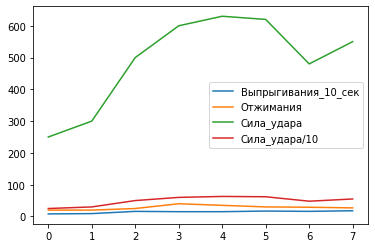

In [108]:
df.plot()

Попробуем для наглядности использовать график "ящик с усами"

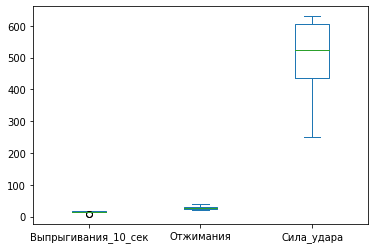

In [84]:
df.plot(kind='box') 

Отдельно посмотрим частотное распределение силы удара

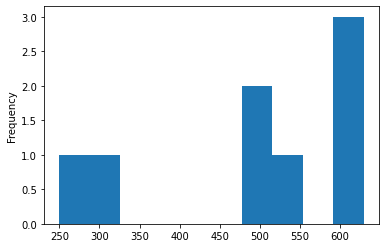

In [85]:
df['Сила_удара'].plot(kind='hist')

Для большей наглядности введём переменную кратную силе удара

In [86]:
df['Сила_удара/10'] = df['Сила_удара']/10
df[['Сила_удара','Сила_удара/10']]

,Сила_удара,Сила_удара/10
0,250,25.0
1,300,30.0
2,500,50.0
3,600,60.0
4,630,63.0
5,620,62.0
6,480,48.0
7,550,55.0


Посмотрим график с полученной кратной переменной и можем выдвинуть предварительную гипотезу о том, что сила удара может больше зависеть от отжиманий, чем от выпрыгиваний.

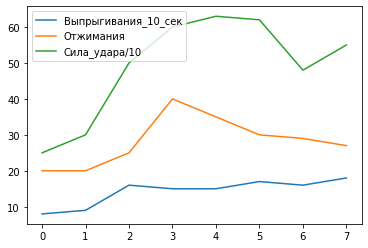

In [87]:
df[['Выпрыгивания_10_сек', 'Отжимания', 'Сила_удара/10']].plot()

Обновлённый график говорит нам о том, что связь между упражнениями скорее будет малозначительной

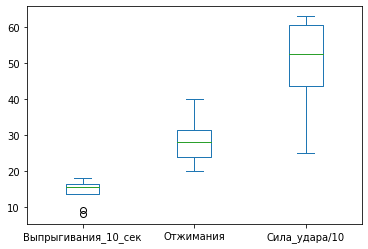

In [88]:
df[['Выпрыгивания_10_сек', 'Отжимания', 'Сила_удара/10']].plot(kind = 'box')

Используем билиотеку scikit-learn для построения линейной регрессионной модели. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html 

In [89]:
from sklearn.linear_model import LinearRegression

Разделим наши данные на зависимую и независимые переменные

In [90]:
X, y = df[['Выпрыгивания_10_сек', 'Отжимания']], df['Сила_удара']

Обучим нашу модель на имеющихся данных

In [91]:
lr = LinearRegression(fit_intercept= False, normalize=True)
lr.fit(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


LinearRegression(fit_intercept=False, normalize=True)

Для проверки модели проведём ещё одни замеры на которых она не обучалась и, результаты которых ей надо будет предсказать.

In [92]:
new_data = {
    'Выпрыгивания_10_сек': [17, 16],
    'Отжимания': [30, 29]
}


In [93]:
test_res =  [610, 600]


In [94]:
x_res = lr.predict(pd.DataFrame(new_data))
x_res

array([562.85873403, 535.87837502])

Как мы видим результаты меньше измеренного на 10%. Для научного исследования это много. Поэтому 1-м домашним заданием будет проведение эксперимента лучшего чем наш.

In [95]:
lr.coef_

array([18.96554125,  8.01481776])

В результате нами была получена формула связывающая упражнения и, которую можно использовать для планирования тренировочного процесса:

 **Сила удара** = **19** х *Отжимания* + **8** х *Выпрыгивания_10_сек*

In [96]:
lr.intercept_

0.0

Посмотрим как это работало на наших данных. Для этого выберем одного спортсмена.Его выпрыгивания равны 16,  отжимания - 25, а сила удара - 500.

In [97]:
df.loc[2]

Выпрыгивания_10_сек     16.0
Отжимания               25.0
Сила_удара             500.0
Сила_удара/10           50.0
Name: 2, dtype: float64

Подставим данные в нашу формулу и убедимся, что рассчётное значение (503.8191039729503) оказалось очень близко к измеренному (500).

In [98]:
lr.intercept_ + lr.coef_[0] * 16 + lr.coef_[1] * 25

503.8191039729503

Определим погрешность допущенную при применении нашей модели по методу наименьших квадратов (MSE). https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html 

Mean Squared Error
MSE (Mean Squared Error, Средняя Квадратическая Ошибка (рус.)) использует похожий принцип сравнения. Эта метрика имеет следующую формулу:

  $MSE(y, y_1) = \frac{1}{n} \cdot \sum_{i = 1}^n (y^i - y_1^i)^2$

Root Mean Squared Deviation
RMSD напрямую связана с MSE — значение этой меры равно корню квадратному из значения MSE для заданных наборов:

  $RMSD(y, y_1) = \sqrt{MSE(y, y_1)} = \sqrt{\frac{1}{n} \cdot \sum_{i=1}^n (y^i - y^i_1)^2)}$

RMSD отсутствует в sklearn, однако мы можем с легкостью вычислить значение этой метрики.

In [99]:
from sklearn.metrics import mean_squared_error

In [100]:
mean_squared_error(test_res, x_res)

3166.9408739330574

Для достижения соразмерности используем извлечение квадратного корня из подученного значения (RMSE)

In [101]:
mean_squared_error(test_res, x_res)**0.5

56.275579729870906

Определим коэффициент детерминации R² https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html 



 $R^2(y, y_1) = 1 - \frac{\sum_{i=1}^{n} (y^i - y_1^i)^2}{\sum_{i=1}^{n} (y^i - y_{mean})^2}$


In [102]:
from sklearn.metrics import r2_score

In [103]:
(test_res, x_res)

([610, 600], array([562.85873403, 535.87837502]))

In [104]:
r2_score(test_res, x_res)

-125.6776349573223

Коэффициент детерминации, или R², является еще одним показателем, который мы можем использовать для оценки модели, и он тесно связан с MSE, но имеет преимущество в том, чтобезмасштабное- не имеет значения, являются ли выходные значения очень большими или очень маленькими,R² всегда будет между -∞ и 1.


Когда R² отрицательно, это означает, что модель хуже, чем предсказание среднего значения.
R² - это соотношение между тем, насколько хороша наша модель, и тем, насколько хороша модель наивного среднего.

# Другие методы оценки
При наличии "выбросов" иногда лучше использовать оценку по модулю ошибки: 
Mean Absolute Error
MAE (Mean Absolute Error, Средняя Абсолютная Ошибка) — мера схожести предсказаний и правильных значений для каких-либо наблюдений. Имеет следующую формулу:

 $MAE(y, y_1) = \frac{1}{n} \cdot \sum_{i=1}^n |y^i - y^i_1|$


Здесь y — предсказанные значения, y_1 — правильные значения для n наблюдений.


При этом методы классификации будут иметь свои методы оценки в отличии от линейной регрессии:


**accuracy** (точность). 




  $\phi_{norm} (y, y_1) = \frac{1}{n} \cdot \sum_{i=1}^n \left[(y^i == y_{1}^i) \right]$


 $\phi (y, y_1) = \sum_{i=1}^n \left[(y^i == y_{1}^i) \right]$


Нормализированная версия представляет собой соотношение кол-ва корректных предсказаний и общего кол-ва меток.
Ненормализированная версия представляет собой просто кол-во верных предсказаний.

**precision** и **recall** очень похожи. вариации для бинарной классификации.



  $PR = \frac{TP}{TP + FP}$



  $RC = \frac{TP}{TP + FN}$

Здесь:

TP (True Positive) — кол-во правильно предсказанных «положительных» меток (предсказание диагноза у пациента, у которого действительно он есть);
FP (False Positive) — кол-во неправильно предсказанных «положительных» меток (предсказание диагноза для пациента, у которого он отсутствует);
FN (False Negative) — кол-во неправильно предсказанных «отрицательных меток» (предсказание отсутствия диагноза у пациента, у которого он есть).

F1 score напрямую связана с precision и recall:

  $F1 = \frac{2 \cdot (PR \cdot RC)}{PR + RC}$




In [117]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error

rmse = np.sqrt(mean_squared_error(test_res, x_res))
r2 = r2_score(test_res, x_res)
print('RMSE:', rmse)
print('R2:', r2)
print("MAE: ", mean_absolute_error(test_res, x_res))

RMSE: 56.275579729870906
R2: -125.6776349573223
MAE:  55.631445477599186


Метрики и оценки: количественная оценка качества прогнозов https://scikit-learn.ru/3-3-metrics-and-scoring-quantifying-the-quality-of-predictions/

Часто бывает полезно усложнить модель, учитывая нелинейные особенности входных данных. Простой и распространенный метод использования — это полиномиальные функции, которые могут получить термины высокого порядка и взаимодействия функций. Реализован в PolynomialFeatures

In [121]:
from sklearn.preprocessing import PolynomialFeatures
df.drop(['Сила_удара/10'], axis=1, inplace=True)
p = PolynomialFeatures(degree=2).fit(df)
p.get_feature_names(df.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1',
 'Выпрыгивания_10_сек',
 'Отжимания',
 'Сила_удара',
 'Выпрыгивания_10_сек^2',
 'Выпрыгивания_10_сек Отжимания',
 'Выпрыгивания_10_сек Сила_удара',
 'Отжимания^2',
 'Отжимания Сила_удара',
 'Сила_удара^2']

In [122]:
p.fit_transform(df)

array([[1.000e+00, 8.000e+00, 2.000e+01, 2.500e+02, 6.400e+01, 1.600e+02,
        2.000e+03, 4.000e+02, 5.000e+03, 6.250e+04],
       [1.000e+00, 9.000e+00, 2.000e+01, 3.000e+02, 8.100e+01, 1.800e+02,
        2.700e+03, 4.000e+02, 6.000e+03, 9.000e+04],
       [1.000e+00, 1.600e+01, 2.500e+01, 5.000e+02, 2.560e+02, 4.000e+02,
        8.000e+03, 6.250e+02, 1.250e+04, 2.500e+05],
       [1.000e+00, 1.500e+01, 4.000e+01, 6.000e+02, 2.250e+02, 6.000e+02,
        9.000e+03, 1.600e+03, 2.400e+04, 3.600e+05],
       [1.000e+00, 1.500e+01, 3.500e+01, 6.300e+02, 2.250e+02, 5.250e+02,
        9.450e+03, 1.225e+03, 2.205e+04, 3.969e+05],
       [1.000e+00, 1.700e+01, 3.000e+01, 6.200e+02, 2.890e+02, 5.100e+02,
        1.054e+04, 9.000e+02, 1.860e+04, 3.844e+05],
       [1.000e+00, 1.600e+01, 2.900e+01, 4.800e+02, 2.560e+02, 4.640e+02,
        7.680e+03, 8.410e+02, 1.392e+04, 2.304e+05],
       [1.000e+00, 1.800e+01, 2.700e+01, 5.500e+02, 3.240e+02, 4.860e+02,
        9.900e+03, 7.290e+02, 1.485e+

In [123]:
features = pd.DataFrame(p.transform(df), columns=p.get_feature_names(df.columns))
features

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,1,Выпрыгивания_10_сек,Отжимания,Сила_удара,Выпрыгивания_10_сек^2,Выпрыгивания_10_сек Отжимания,Выпрыгивания_10_сек Сила_удара,Отжимания^2,Отжимания Сила_удара,Сила_удара^2
0,1.0,8.0,20.0,250.0,64.0,160.0,2000.0,400.0,5000.0,62500.0
1,1.0,9.0,20.0,300.0,81.0,180.0,2700.0,400.0,6000.0,90000.0
2,1.0,16.0,25.0,500.0,256.0,400.0,8000.0,625.0,12500.0,250000.0
3,1.0,15.0,40.0,600.0,225.0,600.0,9000.0,1600.0,24000.0,360000.0
4,1.0,15.0,35.0,630.0,225.0,525.0,9450.0,1225.0,22050.0,396900.0
5,1.0,17.0,30.0,620.0,289.0,510.0,10540.0,900.0,18600.0,384400.0
6,1.0,16.0,29.0,480.0,256.0,464.0,7680.0,841.0,13920.0,230400.0
7,1.0,18.0,27.0,550.0,324.0,486.0,9900.0,729.0,14850.0,302500.0


# Часть 2. Исследование на реальных ("больших") данных

Попробуем применить полученные данные к реальному датасету, который в спортивной науке может быть отнесён к "большим данным" так как содержит описание боёв 3592 профессиональных бойцов ММА по 160 признакам каждый

In [124]:
import numpy as np
import operator
import pandas as pd # Для работы с данными
import scipy.stats # При работе со статистикой
import matplotlib.pyplot as plt  # Библиотека для визуализации результатов
%matplotlib inline

Посмотрим как выглядят первые 5 строк в таблице и заметим, что присутствуют как численные, так и категориальные переменные

In [128]:
data = pd.read_csv('https://raw.githubusercontent.com/vn322/Russian-Sport-University/6c18578b781071f524322145d0a2cc894c28651a/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F%20UFCdata%20-%20preprocessed_data.csv', delimiter = ',')
data.head()

,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,...,weight_class_Women's Strawweight,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,Red,True,5,0,4,0,9.200000,6.000000,0.200000,0.000000,...,0,0,1,0,0,0,0,1,0,0
1,Red,True,5,0,3,0,14.600000,9.100000,11.800000,7.300000,...,0,0,1,0,0,0,0,0,1,0
2,Red,False,3,0,3,0,15.354839,11.322581,6.741935,4.387097,...,0,0,1,0,0,0,0,1,0,0
3,Blue,False,3,0,4,0,17.000000,14.000000,13.750000,11.000000,...,0,0,0,0,0,1,0,1,0,0
4,Blue,False,3,0,1,0,17.000000,14.500000,2.500000,2.000000,...,0,0,0,0,1,0,0,0,1,0


Получим чуть больше информации о типах данных

In [131]:
data.info("all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3592 entries, 0 to 3591
Data columns (total 160 columns):
 #    Column                              Dtype  
---   ------                              -----  
 0    Winner                              object 
 1    title_bout                          bool   
 2    no_of_rounds                        int64  
 3    B_current_lose_streak               int64  
 4    B_current_win_streak                int64  
 5    B_draw                              int64  
 6    B_avg_BODY_att                      float64
 7    B_avg_BODY_landed                   float64
 8    B_avg_CLINCH_att                    float64
 9    B_avg_CLINCH_landed                 float64
 10   B_avg_DISTANCE_att                  float64
 11   B_avg_DISTANCE_landed               float64
 12   B_avg_GROUND_att                    float64
 13   B_avg_GROUND_landed                 float64
 14   B_avg_HEAD_att                      float64
 15   B_avg_HEAD_landed                   

Получим значения основных описательных статистик по переменным каждого столбца

In [132]:
data.describe()

,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,...,weight_class_Women's Strawweight,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
count,3592.000000,3592.000000,3592.000000,3592.0,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,...,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000
mean,3.196548,0.560412,1.126114,0.0,8.800322,6.158010,8.308673,5.615597,53.926193,19.667738,...,0.027283,0.001392,0.768931,0.000557,0.197383,0.031737,0.003341,0.758352,0.210746,0.027561
std,0.664834,0.790660,1.385555,0.0,7.099821,5.077738,7.518370,5.415420,41.194737,16.027255,...,0.162929,0.037288,0.421575,0.023593,0.398079,0.175324,0.057711,0.428142,0.407895,0.163735
min,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.0,3.666667,2.500000,3.000000,2.000000,23.000000,8.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,3.000000,0.000000,1.000000,0.0,7.000000,5.000000,6.467611,4.275253,45.422619,15.572727,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.000000,1.000000,2.000000,0.0,12.275974,8.500000,11.500000,7.857143,74.723214,27.513889,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,5.000000,6.000000,12.000000,0.0,49.000000,39.000000,87.000000,68.000000,271.000000,130.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Так как мы имеем ограничение на количество визуальной информации при выводе на экран, то, можем применять срезы

In [136]:
data.columns[9:20]

Index(['B_avg_CLINCH_landed', 'B_avg_DISTANCE_att', 'B_avg_DISTANCE_landed',
       'B_avg_GROUND_att', 'B_avg_GROUND_landed', 'B_avg_HEAD_att',
       'B_avg_HEAD_landed', 'B_avg_KD', 'B_avg_LEG_att', 'B_avg_LEG_landed',
       'B_avg_PASS'],
      dtype='object')

Выберем две очевидно связанные переменные для анализа.

Ими будут количество попыток ударов выполненных спортсменом из синего угла в область туловища и количество ударов попавших в туловище соперника.

In [137]:
X = data[['B_avg_BODY_att']] # попытки удара
Y = data['B_avg_BODY_landed'] #  удары достигшие цели

Обучим простейшую линейную регрессионную модель

In [138]:
model = LinearRegression()
model.fit(X,Y) # метод фит - метод обучения модели

LinearRegression()

In [139]:
y_predict = model.predict(X) # получаем предсказанное значение
y_predict[:5]

array([ 6.43167345, 10.12910788, 10.64595355, 11.77241207, 11.77241207])

Визуализируем полученную модель в виде линии тренда и убедимся, что действительно она описывает зависимость количества успешных атак туловища от количества попыток таких атак.

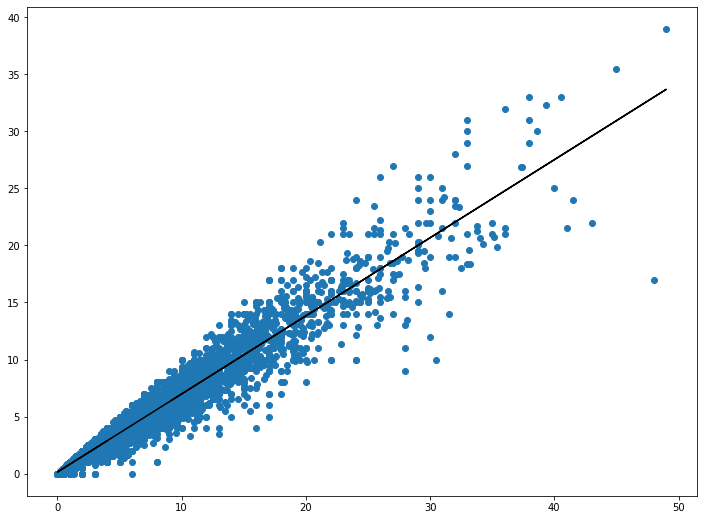

In [140]:
plt.figure(figsize=(12,9))
plt.plot(X, Y, 'o')
plt.plot(X, y_predict, 'k-')
plt.show()

Рассмотрим расширенную модель - зависимость количества успешных атак головы от атак туловища и входов в клинч

In [145]:
# будем использовать набор данных
X = pd.get_dummies(data.loc[:, ['B_avg_CLINCH_landed',  'B_avg_BODY_landed']])
X.head()

,B_avg_CLINCH_landed,B_avg_BODY_landed
0,0.000000,6.000000
1,7.300000,9.100000
2,4.387097,11.322581
3,11.000000,14.000000
4,2.000000,14.500000


In [146]:
Y = data.loc[:, ['B_avg_HEAD_landed']]
Y.head() # предсказываемая 

,B_avg_HEAD_landed
0,11.200000
1,32.000000
2,23.258065
3,53.750000
4,45.000000


In [147]:
model.fit(X, Y)
y_predict = model.predict(X) # обучаем регрессию
y_predict[:5]

array([[17.68178899],
       [23.96088796],
       [25.16481528],
       [30.71265966],
       [27.60540863]])

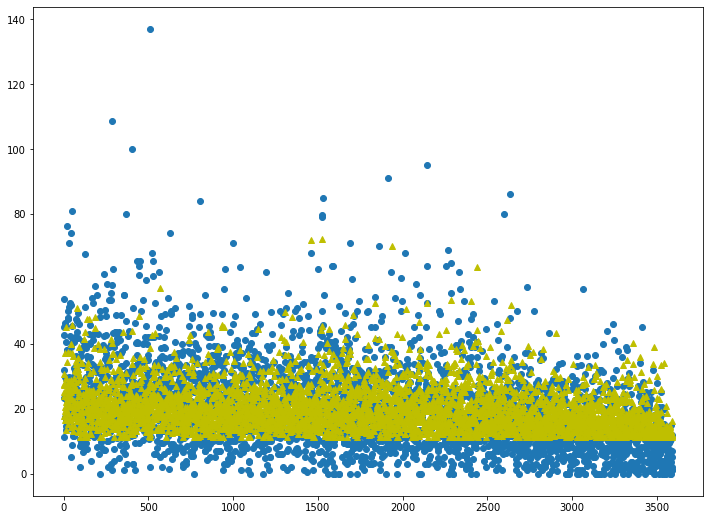

In [148]:
plt.figure(figsize=(12,9))
plt.plot(Y.index, Y, 'o')
plt.plot(Y.index, y_predict, 'y^')
plt.show() #  желтые треугольники показывают предсказанный результат

# Часть 3 Исследование изменения точности моделей в зависимости от увеличения степени полинома.



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score # подгружаем метрику mse и r2
from sklearn.preprocessing import PolynomialFeatures

Создадим  набор данных где у имеет сложную зависимость от х с добавлением случайно генерируемых чисел. $y = 0.5x^3 -2x^2 + x + random$ 

Запомним эту зависимость

In [ ]:
np.random.seed(0)
x = 2- 3 * np.random.normal(0, 1, 20)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 20) # заданы параметры при степенях

# преобразуем данный чтобы добавить новые оси
x = x[:, np.newaxis]
y = y[:, np.newaxis]

Обратим внимание, что зависимость переменных не очевидна и однозначно её предсказать гдядя на этот набор данных не представляется возможным.

In [ ]:
x,y

Сначала используем простую линейную регрессию.

MSE: 15.908242501429998
R2: 0.6386750054827146


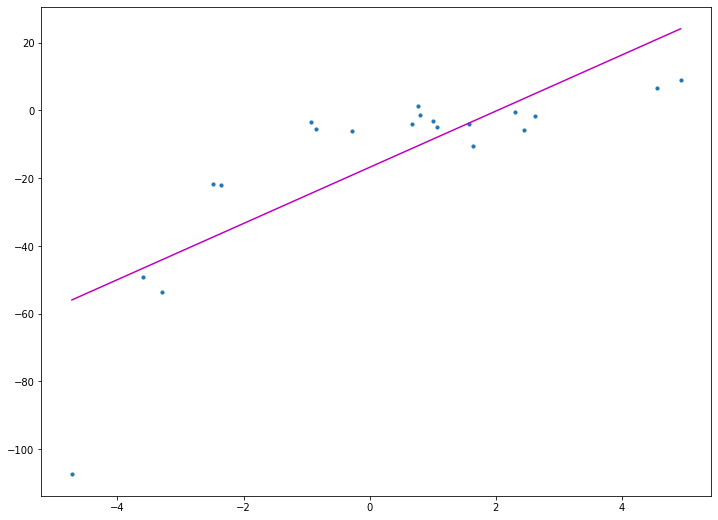

In [ ]:
model = LinearRegression() 
model.fit(x, y)
y_pred = model.predict(x)
plt.figure(figsize=(12,9))

# считаем метрику MSE и R2
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print('MSE:', rmse)
print('R2:', r2)
plt.scatter(x, y, s=10)

# рисуем наши смоделированные данные
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x, y_pred), key=sort_axis)
x_, y_pred = zip(*sorted_zip)

plt.plot(x_, y_pred, color='m')
plt.show()

В результате мы получили рабочую модель с неплохим коэффициентом детерминации/апроксимации.

На втором шаге используем упоминаемую ранее возможность получения дополнительных признаков и рассмотрим полином второй степени.

In [ ]:
# sklearn генерирует допольнительное кол-во признаков для полиномиальной регресии
polynomial_features = PolynomialFeatures(degree=2) # указываем вторую степень полинома
x_poly = polynomial_features.fit_transform(x) # получаем новые признаки

In [ ]:
x_poly

MSE: 10.120437473614713
R2: 0.8537647164420812


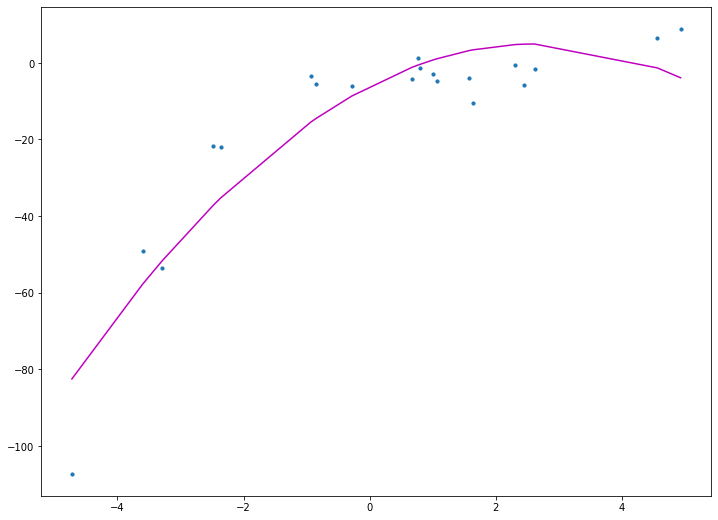

In [ ]:
# теперь подаем эти признаки в линейную регресиию
# и проделаем все те же самые операции
model = LinearRegression(fit_intercept= False) 
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
plt.figure(figsize=(12,9))


rmse = np.sqrt(mean_squared_error(y, y_poly_pred))
r2 = r2_score(y, y_poly_pred)
print('MSE:', rmse)
print('R2:', r2)
plt.scatter(x, y, s=10)

sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x, y_poly_pred), key=sort_axis)
x_, y_poly_pred = zip(*sorted_zip)

plt.plot(x_, y_poly_pred, color='m')
plt.show()

Как можно заметить по значениям оценок качества модели кривая описывает наш набор данных лучше чем прямая.

Запишем уравнение, которым задаётся наша модель.

In [ ]:
model.coef_

array([[-6.11973959,  8.48492679, -1.62853134]])

Уравнение кривой:    $y = -1.62853134x^2 + 8.48492679x - 6.11973959$ 

Округлив для простоты восприятия получим:     $y = -1.6x^2 + 8.5x - 6.1$ 

In [ ]:
model.intercept_

0.0

In [ ]:
x_[:2], y_poly_pred[:2]

((array([-4.7226796]), array([-3.60267397])),
 (array([-82.51360898]), array([-57.82529579])))

Не останавливаясь на достигнутом увеличим степень полинома до третьей.

MSE: 3.449895507408725
R2: 0.9830071790386679


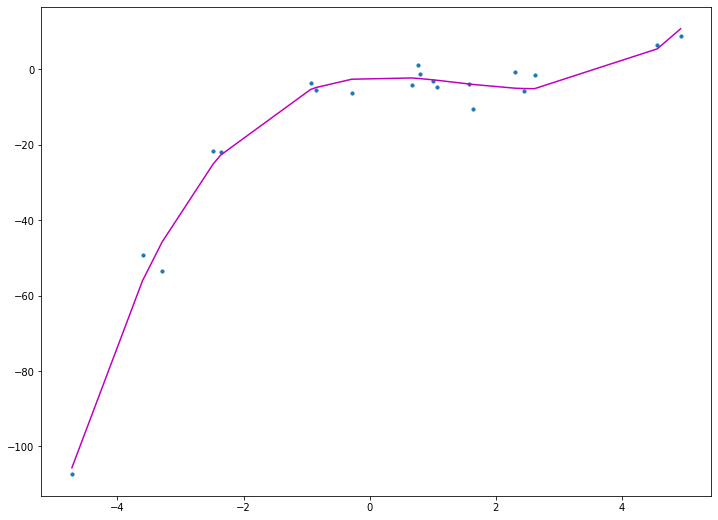

In [ ]:
polynomial_features = PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression() 
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
plt.figure(figsize=(12,9))


rmse = np.sqrt(mean_squared_error(y, y_poly_pred))
r2 = r2_score(y, y_poly_pred)
print('MSE:', rmse)
print('R2:', r2)
plt.scatter(x, y, s=10)

sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x, y_poly_pred), key=sort_axis)
x_, y_poly_pred = zip(*sorted_zip)

plt.plot(x_, y_poly_pred, color='m')
plt.show()

Очевидно, что при увеличении степени полинома кривая всё более точно описывает имеющиеся данные. Однако стоит помнить, что при использовании модели не для описания, а для прогноза мы можем получить переобученную модель и противоречие между точностью и универсальностью модели - это нерешённая проблема.

In [ ]:
model.coef_

array([[ 0.        ,  0.99141388, -2.10330137,  0.49338043]])

В итоге мы получили такое уравнение $y = 0.49338043x^3 -2.10330137x^2 + 0.99141388x$ 


Округлив для простоты восприятия получим $y = 0.5x^3 -2x^2 + x$ и, заметим, что именно это и было нашей исходной зависимостью.



Как мы заметили выше не всегда увеличение степени полинома оправдано. Возьмём в качестве основы именно квадратичную зависимость, которая часто встречается в жизни и спорте, например при метаниях, прыжках и, даже, при описании спортивной карьеры (Ермаков А.В., Мякинченко П.Е. ПРОГНОЗИРОВАНИЕ С ИСПОЛЬЗОВАНИЕМ МЕТОДОВ МАТЕМАТИЧЕСКОГО МОДЕЛИРОВАНИЯ В СПОРТЕ ВЫСШИХ ДОСТИЖЕНИЙ НА ПРИМЕРЕ ЗИМНИХ ВИДОВ СПОРТА // ТиПФК. 2021. №2. URL: https://cyberleninka.ru/article/n/prognozirovanie-s-ispolzovaniem-metodov-matematicheskogo-modelirovaniya-v-sporte-vysshih-dostizheniy-na-primere-zimnih-vidov-sporta (дата обращения: 03.09.2022).).

$y = 13x^2 + 2x + 7$

Используем это уравнение для основы построения наших данных. Далее проведите самостоятельное исследование. 

Text(0.5, 1.0, 'Non Linear Data')

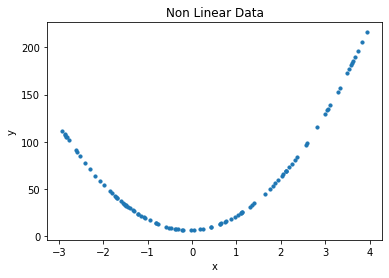

In [ ]:
# Шаг 1: Импортируйте библиотеки и сгенерируйте случайный набор данных.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Importing the dataset
## x = data, y = quadratic equation
x = np.array(7 * np.random.rand(100, 1) - 3)
x1 = x.reshape(-1, 1)
y = 13 * x*x + 2 * x + 7

#Шаг 2: нанесите точки данных.
# data points
plt.scatter(x, y, s = 10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Non Linear Data')


In [ ]:
#Шаг 3: Сначала попробуйте сопоставить данные с  моделью.
# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(x1, y)
print('Slope of the line is', regression_model.coef_)
print('Intercept value is', regression_model.intercept_)
# Predict
y_predicted = regression_model.predict(x1)


Slope of the line is [[14.01245249]]
Intercept value is [57.77801001]


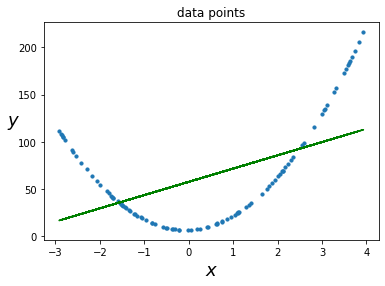

In [ ]:
# Шаг 4: нанесите точки данных и  линию тренда.
plt.scatter(x, y, s = 10)
plt.xlabel("$x$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.title("data points")

# predicted values
plt.plot(x, y_predicted, color ='g')


Даже визуальный анализ показывает несостоятельность идеи использовать прямую линию для описания имеющихся данных.

In [ ]:
#Шаг 5. Рассчитайте производительность модели с точки зрения среднеквадратичной ошибки, среднеквадратичной ошибки и оценки r2.
# model evaluation
mse = mean_squared_error(y, y_predicted)

rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)

# printing values

print('RMSE of Linear model', mse**0.5)

print('R2 score of Linear model: ', r2)


RMSE of Linear model 46.978679840569214
R2 score of Linear model:  0.26713842693079426


Производительность линейной модели неудовлетворительна. Используем полиномиальную регрессию со степенью 2.

In [ ]:
#Шаг 6: Для повышения производительности нам нужно немного усложнить модель. Итак, давайте установим многочлен степени 2 и перейдем к линейной регрессии.
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
x_poly = poly_features.fit_transform(x1)
x[3], x_poly[3]



(array([2.9906234]), array([2.9906234, 8.9438283]))

В дополнение к столбцу x был введен еще один столбец, который представляет собой квадрат фактических данных. Теперь мы переходим к простой линейной регрессии

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_poly, y)
print('Coefficients of x are', lin_reg.coef_)
print('Intercept is', lin_reg.intercept_)


Coefficients of x are [[ 2. 13.]]
Intercept is [7.]


Получили   искомое   уравнение $13x^2 + 2x + 7$

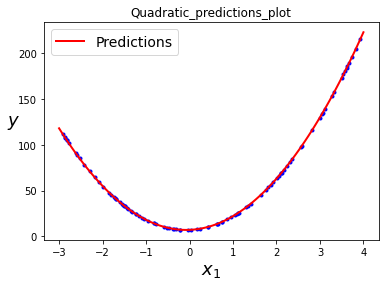

In [ ]:
#Шаг 7: Постройте полученное квадратное уравнение.
x_new = np.linspace(-3, 4, 100).reshape(100, 1)
x_new_poly = poly_features.transform(x_new)
y_new = lin_reg.predict(x_new_poly)
plt.plot(x, y, "b.")
plt.plot(x_new, y_new, "r-", linewidth = 2, label ="Predictions")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.legend(loc ="upper left", fontsize = 14)

plt.title("Quadratic_predictions_plot")
plt.show()


In [ ]:
#Шаг 8: Вычислите производительность модели, полученной с помощью полиномиальной регрессии.
y_deg2 = lin_reg.predict(x_poly)
# model evaluation
mse_deg2 = mean_squared_error(y, y_deg2)

r2_deg2 = r2_score(y, y_deg2)

# printing values

print('RMSE of Polyregression model', mse_deg2**0.5)

print('R2 score of Linear model: ', r2_deg2)


RMSE of Polyregression model 2.3825375761547512e-14
R2 score of Linear model:  1.0


Производительность модели полиномиальной регрессии намного лучше, чем модель линейной регрессии для данного квадратного уравнения.
Важные факты: мы достигли коэффициента детерминации равным 1 и очень маленькой погрешности, это максимальное значение и дальнейшее повышение степени полинома не даст улучшения модели.

Вывод: полиномиальная регрессия является эффективным способом работы с нелинейными данными, поскольку она может находить взаимосвязи между функциями, которые не удается выполнить простой линейной регрессионной модели.

# Часть 4 Использование библиотек глубокого обучения

Различные свойства линейной регрессии и ее реализации на Python были рассмотрены ранее. Теперь мы попоробуем  реализовать это в PyTorch - очень популярной библиотеке deep learning, которая разрабатывается Facebook. Тензорные вычисления — основа PyTorch, вокруг которых наращивается вся остальная функциональность. 
Однако несмотря на то, что глубокое обучение является мощным инструментом, но даже простые регрессионные модели могут показать лучшую продуктивность.

In [43]:
import torch
from torch.autograd import Variable


Определяем  данные и присваиваем их переменным x_data и y_data, следующим образом $y = x^2$
Иными словами мы имеем более простое квадратное уравнение, чем те с которыми легко справлялась полиномиальная регрессия ранее.

In [151]:
x_data = Variable(torch.Tensor([[1.0], [2.0], [3.0], [4.0], [5.0]]))
y_data = Variable(torch.Tensor([[1.0], [4.0], [9.0], [16.0], [25.0]]))

print(x_data) 
y_data

tensor([[1.],
        [2.],
        [3.],
        [4.],
        [5.]])


tensor([[ 1.],
        [ 4.],
        [ 9.],
        [16.],
        [25.]])

Здесь **x_data** - наша независимая переменная, а **y_data** - наша зависимая переменная. На данный момент это будет наш набор данных. Далее нам нужно определить нашу модель. Есть два основных шага, связанных с определением нашей модели. Они:
 

1.   Инициализируем нашу модель
2.   Объявляем прямой проход.


Мы используем класс, приведенный ниже:

In [152]:
class LinearRegressionModel(torch.nn.Module):

	def __init__(self):
		super(LinearRegressionModel, self).__init__()
		self.linear = torch.nn.Linear(1, 1) # One in and one out

	def forward(self, x):
		y_pred = self.linear(x)
		return y_pred


Как вы можете видеть, наш класс модели является подклассом torch.nn.module. Кроме того, поскольку здесь у нас есть только один вход и один выход, мы используем линейную модель с размером ввода и вывода, равным 1.
Затем мы создаем объект этой модели.

In [153]:
# our model
our_model = LinearRegressionModel()


После этого мы выбираем оптимизатор и критерии потерь. Здесь мы будем использовать среднеквадратичную ошибку (MSE) в качестве нашей функции потерь и стохастический градиентный спуск (SGD) в качестве нашего оптимизатора. Кроме того, мы произвольно фиксируем скорость обучения 0,01.

In [154]:
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.01)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Теперь мы переходим к нашему этапу обучения. Мы выполняем следующие задачи 500 раз во время обучения:
 





1.   Выполнить прямой проход в обход наших данных и найдити прогнозируемое значение y.
2.  Вычислить потери с помощью MSE.
3. Сбросить все градиенты до 0, выполнить обратное распространение, а затем обновить веса.



In [155]:
for epoch in range(500):

	# Forward pass: Compute predicted y by passing
	# x to the model
	pred_y = our_model(x_data)

	# Compute and print loss
	loss = criterion(pred_y, y_data)

	# Zero gradients, perform a backward pass,
	# and update the weights.
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	print('epoch {}, loss {}'.format(epoch, loss.item()))


epoch 0, loss 1400.294677734375
epoch 1, loss 119.33430480957031
epoch 2, loss 74.41832733154297
epoch 3, loss 71.00547790527344
epoch 4, loss 69.04795837402344
epoch 5, loss 67.20095825195312
epoch 6, loss 65.41741943359375
epoch 7, loss 63.69368362426758
epoch 8, loss 62.027774810791016
epoch 9, loss 60.41770935058594
epoch 10, loss 58.86161804199219
epoch 11, loss 57.35765838623047
epoch 12, loss 55.9041633605957
epoch 13, loss 54.49936294555664
epoch 14, loss 53.14165496826172
epoch 15, loss 51.829498291015625
epoch 16, loss 50.56129455566406
epoch 17, loss 49.33560562133789
epoch 18, loss 48.15104675292969
epoch 19, loss 47.00617599487305
epoch 20, loss 45.89967727661133
epoch 21, loss 44.83026885986328
epoch 22, loss 43.796714782714844
epoch 23, loss 42.79780197143555
epoch 24, loss 41.83240509033203
epoch 25, loss 40.899349212646484
epoch 26, loss 39.99760437011719
epoch 27, loss 39.12604904174805
epoch 28, loss 38.283721923828125
epoch 29, loss 37.469627380371094
epoch 30, loss

После завершения обучения мы проверяем, получаем ли мы правильные результаты, используя модель, которую мы определили. Итак, мы проверяем его на неизвестное значение x_data, в данном случае на следующем значении = 6.0.

In [156]:
new_var = Variable(torch.Tensor([[6.0]]))
pred_y = our_model(new_var)
print("Предсказание для 6 должно быть 36, а у нас - ", our_model(new_var).item())


предсказание для 6 должно быть 36, а у нас -  28.998903274536133


Таким образом глубокое обучение не всегда самый лучший подход и иногда полиномиальная регрессия является оптимльным решением. Хотя для простой линейной регрессии  $y = 2x$ точно такой же подход показывает хороший результат.

In [159]:
import torch
from torch.autograd import Variable

x_data = Variable(torch.Tensor([[1.0], [2.0], [3.0]]))
y_data = Variable(torch.Tensor([[2.0], [4.0], [6.0]]))


class LinearRegressionModel(torch.nn.Module):

	def __init__(self):
		super(LinearRegressionModel, self).__init__()
		self.linear = torch.nn.Linear(1, 1) # One in and one out

	def forward(self, x):
		y_pred = self.linear(x)
		return y_pred

# our model
our_model = LinearRegressionModel()

criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.01)

for epoch in range(500):

	# Forward pass: Compute predicted y by passing
	# x to the model
	pred_y = our_model(x_data)

	# Compute and print loss
	loss = criterion(pred_y, y_data)

	# Zero gradients, perform a backward pass,
	# and update the weights.
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	#print('epoch {}, loss {}'.format(epoch, loss.item()))

new_var = Variable(torch.Tensor([[4.0]]))
pred_y = our_model(new_var)
print("Прогноз для 4 = ", our_model(new_var).item())


Прогноз для 4 =  7.971739768981934


# Дополнительный материал

Используя интерактивные модели автора https://github.com/fbeilstein вы можете получить визуализацию регрессионных моделей

In [160]:
#@title # Explore overfit and underfit
#@markdown Consider the following demo.
#@markdown Blue dots are datapoints (training set).
#@markdown Solid line is a result of ML algorithm that does regression.
#@markdown You should gain some intuition on how dataset size, model complexity, and noise interact.
#@markdown Change parameters until you are able to predict the "goodness" of the result.

#@markdown **1.** Set the dataset size and noise

import plotly.graph_objects as go
import numpy as np


rng = np.random.RandomState(1)
dataset_size = 86  #@param {type: "slider", min: 20, max: 100}
noise = 2.3 #@param {type: "slider", min: 0.0, max: 3.0, step:0.1}
x = 10 * rng.rand(dataset_size)
y = 5 - (5-x)**2 + rng.randn(dataset_size)*noise #20.0 * np.sin(x * 2.0) * np.exp(-x/4.0) + rng.randn(dataset_size)*noise
x_true = np.linspace(0.0, 10.0, 500)
y_true = 5 - (5-x_true)**2 #20.0 * np.sin(x_true * 2.0) * np.exp(-x_true/4.0)

#@markdown **2.** Run the code snippet to get the plot

#@markdown **3.** Use slider "model complexity" to grasp the idea, how model's complexity influences the result.


# Create figure
fig = go.Figure()

# Add traces, one for each slider step
steps = []
for model_complexity in range(1, 60):
  P = np.polyfit(x, y, model_complexity, full=True)
  xfit = np.linspace(0, 10, 1000)
  yfit = np.polyval(P[0], xfit)
  fig.add_trace(
    go.Scatter(
      visible=False,
      line=dict(color="rgba(0,165,0,84)", width=2),
      name="model (complexity: " + str(model_complexity) + ")",
      x=xfit,
      y=yfit))
  step = dict(
    method="restyle",
    args=["visible", [False] * 59 + [True, True]],
    label=str(model_complexity))
  step["args"][1][model_complexity-1] = True  # Toggle i'th trace to "visible"
  steps.append(step)

fig.add_trace(
  go.Scatter(
    visible=True,
    mode="markers",
    marker=dict(color="#0000D1"),
    name="training set",
    x=x,
    y=y))


fig.add_trace(
  go.Scatter(
    visible=True,
    line=dict(color="rgba(0,101,197, 0.5)", width=2.5),
    name="true function",
    x=x_true,
    y=y_true))

# Make 0th trace visible
fig.data[0].visible = True
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Model complexity: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    width=1200, height=600,
    sliders=sliders,
    yaxis = {'range': [-20.0, 10.0], 'autorange':False}
)

fig.show()

In [162]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
  """Uniformly spaced Gaussian features for one-dimensional input"""
  
  def __init__(self, N, width_factor=1.0):
    self.N = N
    self.width_factor = width_factor

  @staticmethod
  def _gauss_basis(x, y, width, axis=None):
    arg = (x - y) / width
    return np.exp(-0.5 * np.sum(arg ** 2, axis))

  def fit(self, X, y=None):
    # create N centers spread along the data range
    if self.N == 1:
      self.width_ = self.width_factor * (X.max() - X.min()) * 0.5
      self.centers_ = np.array([(X.max() + X.min()) * 0.5])
    else:
      self.centers_ = np.linspace(X.min(), X.max(), self.N)
      self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
    return self
  
  def transform(self, X):
    return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def fit_model(X, Y):
  model = make_pipeline(LinearRegression())
  model.fit(X, Y)
  return model

In [163]:
#@title Polynomial basis regression
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize_model(model, X):
  import seaborn as sns
  sns.set()
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  
  # Plot the training points
  ax.scatter(X[:, 0], X[:, 1], c='r', s=30, zorder=3)
  ax.axis('tight')
  xlim = [-1, 1]
  ylim = [-1, 1]
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  
  # fit the estimator
  xfit = np.linspace(-1.0, 1.0, 100)
  yfit = model.predict(xfit[:, np.newaxis])
  ax.plot(xfit, yfit, c='r');

  plt.close(fig)
  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json

def invoke(pts):
  data = np.array(pts).reshape((-1, 2))
  X = data / 300.0 - 1.0
  X[:, 1] *= -1.0
  model = fit_model(X[np.newaxis, :, 0].T, X[:, 1])
  img = figure_to_base64(visualize_model(model, X))

  return IPython.display.JSON({'image': img})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(200, 50, 50, 0.7)';
      ctx.fill();
    }
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });
        
        
        
      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image;
    }

  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:275px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> Add data point
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move data point
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete data point
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>
    <button type="button" onclick="calculate();">
      Do regression
    </button>
  </div>
  <script> init();</script>
'''



def generate_html():
  s = main_str
  return s
  
display(IPython.display.HTML(generate_html()))
output.register_callback('notebook.InvSVM', invoke)

In [165]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model(X, Y):
  model = make_pipeline(PolynomialFeatures(1), LinearRegression())
  model.fit(X, Y)
  return model

In [166]:
#@title Errors Visualization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize_model(model, X):
  import seaborn as sns
  sns.set()
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  
  # Plot the training points
  ax.scatter(X[:, 0], X[:, 1], c='r', s=30, zorder=3)
  ax.axis('tight')
  xlim = [-1, 1]
  ylim = [-1, 1]
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  
  # fit the estimator
  xfit = np.linspace(-1.0, 1.0, 100)
  yfit = model.predict(xfit[:, np.newaxis])
  ax.plot(xfit, yfit, c='r');

  plt.close(fig)
  return fig

def visualize_diffs(model, X):
  import seaborn as sns
  sns.set()
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-30)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))

  x = X[:, 0]
  y = X[:, 1] - model.predict(x[:, np.newaxis])
  ax.scatter(x, y, c='r', s=30, zorder=3)
  ax.axis('tight')
  xlim = [-1, 1]
  ylim = [-1, 1]
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  ax.set_aspect(0.5)

  for x_, y_ in zip(x, y):
    ax.plot([x_, x_], [0, y_], c='g')
  ax.axhline(0.0, c='r')

  plt.close(fig)
  return fig


import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json

def invoke(pts):
  data = np.array(pts).reshape((-1, 2))
  X = data / 300.0 - 1.0
  X[:, 1] *= -1.0
  model = fit_model(X[np.newaxis, :, 0].T, X[:, 1])
  img = figure_to_base64(visualize_model(model, X))
  img_d = figure_to_base64(visualize_diffs(model, X))

  return IPython.display.JSON({'image': img, 'diffs':img_d})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();
    var diff_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(200, 50, 50, 0.7)';
      ctx.fill();
    }
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        ctx.drawImage(diff_image, 0, 600, 600, 300);
        ctx.strokeRect(0, 600, 600, 300);

        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });
        
        
        
      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600 || y >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image;
      diff_image.src = 'data:image/  png;base64,' + params.diffs;
    }

  </script>
  <canvas id="canvas" width="800" height="900" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:275px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> Add data point
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move data point
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete data point
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>
    <button type="button" onclick="calculate();">
      Do regression
    </button>
  </div>
  <script> init();</script>
'''



def generate_html():
  s = main_str
  return s
  
display(IPython.display.HTML(generate_html()))
output.register_callback('notebook.InvSVM', invoke)